## STYLE TRANSFER IN IMAGE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lbfgs as lbfgs
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
'''
Building a deep convolution neural network with 5 convolution blocks, followed by fully connected layers, for multi-class image classification
'''
class ConvNet(nn.Module):
    def __init__(self, n):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*8*8, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, n), nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x


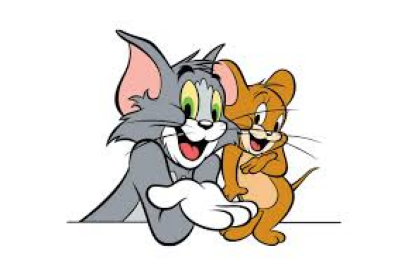

In [10]:
image = Image.open(r"cartoon1.jpeg")
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
def image_preprocessing(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

        # transforms.Lambda(lambda x: x.div(255))  # Ensure scaling is similar
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device, torch.float)
    return image


In [4]:
def image_postprocessing(tensor):
    # Reverse normalization for post-processing
    mean = torch.tensor([0.485, 0.456, 0.406]).to(tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).to(tensor.device).view(1, 3, 1, 1)

    # Un-normalize the image
    tensor = tensor * std + mean

    # Clip values to be in range [0, 1] and convert to numpy array for visualization
    tensor = torch.clamp(tensor, 0, 1)

    image = tensor.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()  # Convert to HWC format for display

    # Convert to range [0, 255] and uint8 for display
    image = (image * 255).astype('uint8')

    return Image.fromarray(image)


In [5]:
# def image_postprocessing(tensor):
#     image = tensor.cpu().clone()
#     image = image.squeeze(0)
#     image = image.mul(255).clamp(0, 255)
#     image = transforms.ToPILImage()(image)
#     return image


# Feature extraction step

In [6]:
def get_features(model, image, layer_names):
    features = []
    x = image
    for name, layer in model.features._modules.items():
        x = layer(x)
        if int(name) in layer_names:
            features.append(x)
    return features


In [7]:
def get_content_features(model, image):
    content_layers = [22]
    return get_features(model, image, content_layers)[0]
def get_style_features(model, image):
    style_layers = [0, 5, 10, 19, 26]
    return get_features(model, image, style_layers)


In [8]:
def content_loss(content, generated):
    return torch.mean((content - generated) ** 2)
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram
def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return torch.mean((style_gram - generated_gram) ** 2)


In [9]:
# def mmd_loss(F_style, F_gen, sigma=1.0):
#     # F_style and F_gen are feature maps from the style and generated images
#     def gaussian_kernel(x, y, sigma=1.0):
#         # Compute the Gaussian kernel between x and y
#         dist = torch.cdist(x, y, p=2)  # Pairwise Euclidean distance
#         kernel_val = torch.exp(-dist ** 2 / (2 * sigma ** 2))  # Gaussian kernel
#         return kernel_val

#     # MMD is computed as the difference between style and generated image feature maps
#     K_XX = gaussian_kernel(F_style, F_style)
#     K_YY = gaussian_kernel(F_gen, F_gen)
#     K_XY = gaussian_kernel(F_style, F_gen)

#     mmd_val = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()

#     return mmd_val
# def style_loss(style_features, generated_features):
#     style_loss_val = 0
#     for style_feat, gen_feat in zip(style_features, generated_features):
#         style_loss_val += mmd_loss(style_feat, gen_feat, sigma=1.0)
#     return style_loss_val


## Calculation of total cumulative loss of both content features and style features.

In [10]:
def total_loss(model, content_image, style_image, generated_image, epoch, epochs = 100):
    content_weight = 0.1
    style_weight = 0.9

    content_features = get_content_features(model, content_image)
    generated_content = get_content_features(model, generated_image)

    style_features = get_style_features(model, style_image)
    generated_style = get_style_features(model, generated_image)

    content_loss_val = content_loss(content_features, generated_content)
    # style_loss_val = style_loss(style_features, generated_style)

    style_loss_val = 0
    for style, generated in zip(style_features, generated_style):
        style_loss_val += style_loss(style, generated)

    total_loss_val = content_weight * content_loss_val + style_weight * style_loss_val
    return total_loss_val


## Style transfer function

In [13]:
def style_transfer(content_path, style_path, epochs=100, device='cuda'):
    content_image = image_preprocessing(content_path, device)
    style_image = image_preprocessing(style_path, device)

    model = ConvNet(n=1).to(device).eval()  # Use the custom ConvNet instead of VGG
    generated_image = content_image.clone().requires_grad_(True)

    optimizer = optim.Adam([generated_image], lr=0.003)

    for epoch in range(epochs):
      optimizer.zero_grad()
      loss = total_loss(model, content_image, style_image, generated_image, epoch)
      loss.backward()
      optimizer.step()




    #optimizer = optim.Adam([generated_image], lr=0.01)
    # optimizer = lbfgs.LBFGS([generated_image], lr=0.01)
    # current_loss = 0
    # for epoch in range(epochs):
    #   def closure():
    #     nonlocal current_loss
    #     optimizer.zero_grad()
    #     loss = total_loss(model, content_image, style_image, generated_image, epoch)
    #     loss.backward()
    #     current_loss = loss.item()
    #     return loss
    #   optimizer.step(closure)

      if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        final_img = image_postprocessing(generated_image.detach())
        plt.figure()
        plt.imshow(final_img)
        plt.title(f'Epoch {epoch} - Generated Image')
        plt.axis('off')
        plt.show()

    final_img = image_postprocessing(generated_image)
    # final_img = final_img.cpu().detach().numpy()
    return final_img


## Image style transfer

Epoch 0, Loss: 1752151040.0


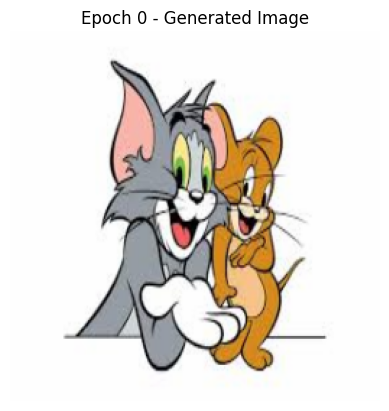

Epoch 10, Loss: 1666978688.0


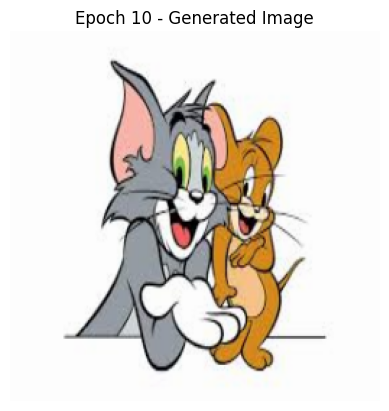

Epoch 20, Loss: 1585671808.0


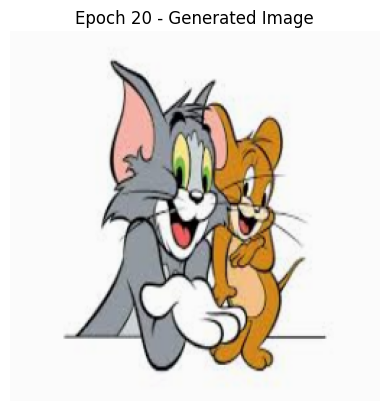

Epoch 30, Loss: 1508470400.0


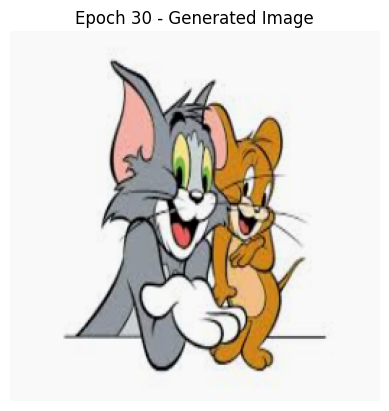

Epoch 40, Loss: 1435427968.0


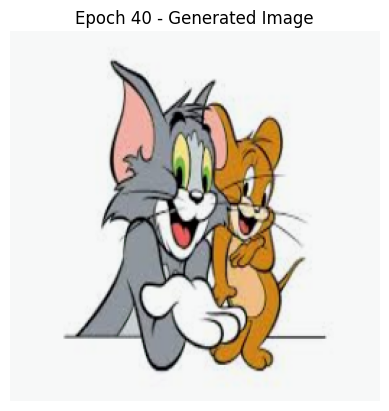

Epoch 50, Loss: 1366444032.0


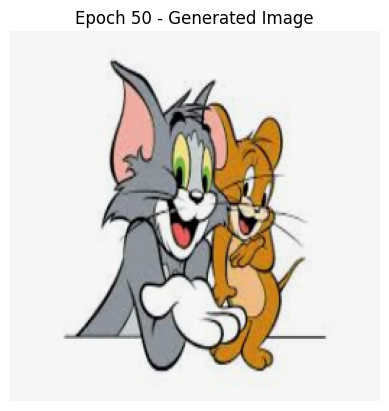

Epoch 60, Loss: 1301340416.0


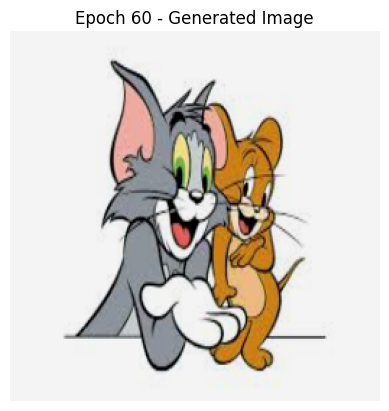

Epoch 70, Loss: 1239898368.0


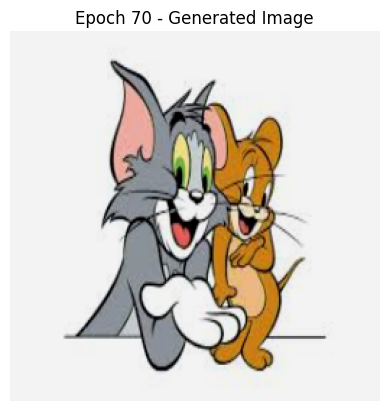

Epoch 80, Loss: 1181894784.0


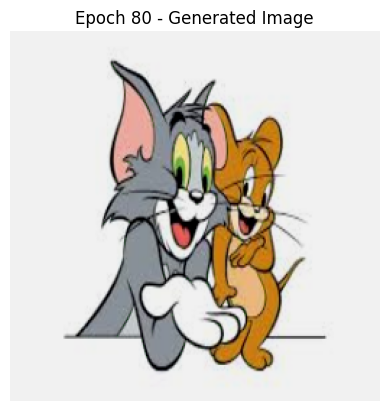

Epoch 90, Loss: 1127110784.0


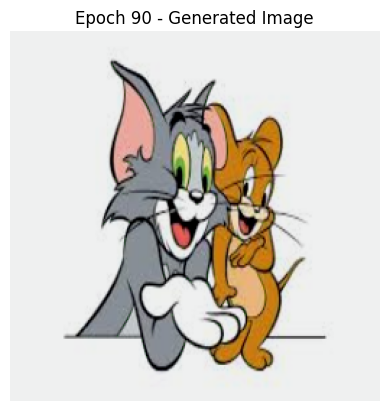

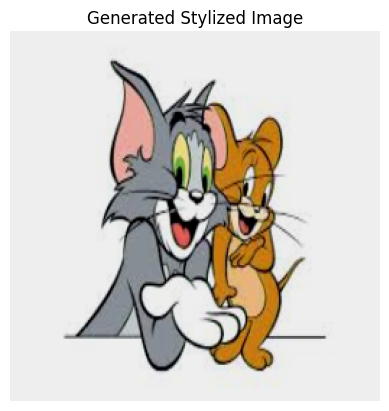

In [14]:
content_image_path = r"cartoon1.jpeg"
style_image_path = r"style2.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_image = style_transfer(content_image_path, style_image_path, device=device)

plt.imshow(generated_image)
plt.title("Generated Stylized Image")
plt.axis("off")
plt.show()
